In [69]:
import os
import re
import pandas as pd
from bs4 import BeautifulSoup

In [71]:
# 设置文件路径
base_dir = r"F:\tesla-optimus-business-analysis\data\raw"
html_file_path = os.path.join(base_dir, "tsla-20241231.html")
output_excel_path = os.path.join(base_dir, "tesla_cash_flow_statements.xlsx")
print(f"正在从 {html_file_path} 读取HTML文件...")

正在从 F:\tesla-optimus-business-analysis\data\raw\tsla-20241231.html 读取HTML文件...


In [72]:
# 读取 HTML 文件
try:
    with open(html_file_path, "r", encoding="windows-1252") as f:
        content = f.read()
    print("HTML文件读取成功")
except Exception as e:
    print(f"读取文件时出错: {e}")
    # 尝试其他编码
    encodings = ['utf-8', 'latin-1', 'iso-8859-1']
    for encoding in encodings:
        try:
            with open(html_file_path, "r", encoding=encoding) as f:
                content = f.read()
            print(f"HTML文件读取成功 ({encoding}编码)")
            break
        except:
            continue
    else:
        print("无法使用任何编码读取文件")
        exit(1)

HTML文件读取成功


In [73]:
# 解析 HTML
soup = BeautifulSoup(content, "html.parser")

print("正在查找现金流量表...")

正在查找现金流量表...


In [74]:
# 清理和转换文本为数字的函数
def clean_and_convert(value):
    if isinstance(value, str):
        # 去除所有空格
        value = value.strip()
        # 替换多个空格为单个空格
        value = re.sub(r'\s+', ' ', value)
        
        # 检查是否为空
        if not value:
            return value
            
        # 检查是否为纯文本（不包含数字）
        if re.search(r'^[a-zA-Z\s\-\.\(\)]+$', value) and not re.search(r'\d', value):
            return value
        
        # 处理括号表示的负数
        if value.startswith('(') and value.endswith(')'):
            value = '-' + value[1:-1]
        
        # 处理带括号的数字，如 "(1,234)" -> -1234
        if '(' in value and ')' in value:
            value = re.sub(r'[\(\)]', '', value)
            if value and not value.startswith('-'):
                value = '-' + value
        
        # 去除货币符号、逗号等非数字字符（保留小数点、负号和数字）
        # 保存原始值用于调试
        original_value = value
        
        # 检查是否有数字
        if re.search(r'\d', value):
            # 去除千位分隔符逗号
            value = value.replace(',', '')
            # 去除美元符号和其他货币符号
            value = re.sub(r'[$€£¥]', '', value)
            # 去除百分号（如果有的话）
            value = value.replace('%', '')
            # 去除其他非数字字符，但保留负号和小数点
            value = re.sub(r'[^\d\.\-]', '', value)
            
            # 检查是否为数字
            if value and re.search(r'^-?\d*\.?\d+$', value):
                try:
                    # 如果是整数，转换为整数
                    if '.' not in value:
                        return int(value)
                    # 否则转换为浮点数
                    return float(value)
                except:
                    return original_value
        
        return original_value
    return value


In [75]:
# 查找现金流量表
def find_cash_flow_table():
    # 方法1: 查找包含现金流量表标题的表格
    cash_flow_keywords = [
        "Consolidated Statements of Cash Flows",
        "Cash Flows",
        "CASH FLOWS",
        "STATEMENTS OF CASH FLOWS"
    ]
    
    # 查找所有表格
    all_tables = soup.find_all("table")
    
    # 用于存储找到的现金流量表
    cash_flow_tables = []
    
    for i, table in enumerate(all_tables):
        # 获取表格及其周围文本
        table_text = table.get_text(strip=True)
        
        # 检查表格文本是否包含现金流量表关键词
        for keyword in cash_flow_keywords:
            if keyword in table_text:
                print(f"找到现金流量表 (表格 {i+1})")
                cash_flow_tables.append((i, table))
                break
        
        # 检查表格前的文本
        prev_siblings = []
        for sibling in table.previous_siblings:
            if sibling.name and sibling.name == 'div':
                prev_siblings.append(sibling.get_text(strip=True))
            elif isinstance(sibling, str):
                prev_siblings.append(sibling.strip())
        
        prev_text = " ".join(prev_siblings[:5])  # 查看前5个兄弟元素
        
        for keyword in cash_flow_keywords:
            if keyword in prev_text:
                print(f"找到现金流量表 (表格 {i+1}, 在表格前发现关键词)")
                cash_flow_tables.append((i, table))
                break
    
    return cash_flow_tables

In [76]:
# 查找现金流量表
cash_flow_tables = find_cash_flow_table()

if not cash_flow_tables:
    print("未找到标题为'Consolidated Statements of Cash Flows'的表格")
    print("尝试查找包含现金流量信息的表格...")
    
    # 查找所有表格，然后筛选可能包含现金流量信息的表格
    all_tables = soup.find_all("table")
    cash_items = [
        "Cash flows from operating activities",
        "Cash flows from investing activities",
        "Cash flows from financing activities",
        "Net cash provided by operating activities",
        "Net cash used in investing activities",
        "Net cash used in financing activities",
        "Net increase in cash and cash equivalents",
        "Cash and cash equivalents at beginning of period",
        "Cash and cash equivalents at end of period"
    ]
    
    for i, table in enumerate(all_tables):
        table_text = table.get_text().upper()
        # 检查是否包含多个现金流量项目
        matches = [item for item in cash_items if item.upper() in table_text]
        if len(matches) >= 3:  # 如果有至少3个现金流量项目，可能是现金流量表
            print(f"找到可能为现金流量表的表格 (表格 {i+1})")
            print(f"包含的项目: {matches[:3]}...")
            cash_flow_tables.append((i, table))

找到现金流量表 (表格 22)
找到现金流量表 (表格 27)


In [77]:
# 提取并处理现金流量表数据
all_cash_flow_data = []

if cash_flow_tables:
    print(f"\n找到 {len(cash_flow_tables)} 个可能的现金流量表")
    
    for table_idx, table in cash_flow_tables:
        print(f"\n正在处理表格 {table_idx+1}...")
        
        # 提取表格的所有行
        rows = table.find_all("tr")
        
        if not rows:
            # 尝试不同的行查找方式
            rows = table.find_all(["tr", "tbody>tr"])
        
        table_data = []
        
        # 提取每一行的数据
        for row_idx, row in enumerate(rows):
            # 提取所有单元格
            cells = row.find_all(["td", "th"])
            
            if not cells:
                # 尝试其他方式查找单元格
                cells = row.find_all(["td", "th", "span"])
            
            cell_texts = []
            for cell in cells:
                # 获取文本，去除多余空格
                text = cell.get_text(" ", strip=True)
                text = re.sub(r'\s+', ' ', text).strip()
                if text:
                    cell_texts.append(text)
            
            if cell_texts:
                table_data.append(cell_texts)
        
        # 清理和转换数值
        cleaned_table_data = []
        for row in table_data:
            cleaned_row = [clean_and_convert(cell) for cell in row]
            cleaned_table_data.append(cleaned_row)
        
        # 添加到总数据中
        if cleaned_table_data:
            # 添加表格标题
            all_cash_flow_data.append([f"现金流量表 - 表格{table_idx+1}"])
            all_cash_flow_data.extend(cleaned_table_data)
            all_cash_flow_data.append([])  # 添加空行分隔
        
        # 显示表格大小
        print(f"表格 {table_idx+1}: {len(cleaned_table_data)} 行, 最大 {max(len(row) for row in cleaned_table_data) if cleaned_table_data else 0} 列")
        
        # 显示前几行数据预览
        if cleaned_table_data:
            print("前5行数据预览:")
            for i in range(min(5, len(cleaned_table_data))):
                row_preview = []
                for cell in cleaned_table_data[i]:
                    if isinstance(cell, (int, float)):
                        row_preview.append(f"{cell:,.0f}")
                    else:
                        row_preview.append(str(cell)[:20])
                print(f"  行{i+1}: {' | '.join(row_preview)}")


找到 2 个可能的现金流量表

正在处理表格 22...
表格 22: 8 行, 最大 2 列
前5行数据预览:
  行1: Page
  行2: -238 | 46
  行3: Consolidated Balance | 48
  行4: Consolidated Stateme | 49
  行5: Consolidated Stateme | 50

正在处理表格 27...
表格 27: 49 行, 最大 7 列
前5行数据预览:
  行1: 31
  行2: 2,024 | 2,023 | 2,022
  行3: Cash Flows from Oper
  行4: Net income | $ | 7,153 | $ | 14,974 | $ | 12,587
  行5: Adjustments to recon


In [78]:
# 保存数据到Excel
if all_cash_flow_data:
    print(f"\n准备保存数据...")
    
    # 找到最大列数
    max_cols = max(len(row) for row in all_cash_flow_data)
    
    # 对齐所有行的列数
    aligned_data = []
    for row in all_cash_flow_data:
        if len(row) < max_cols:
            row = row + [""] * (max_cols - len(row))
        aligned_data.append(row)
    
    # 创建DataFrame
    df = pd.DataFrame(aligned_data)
    
    print(f"总数据: {len(df)} 行, {df.shape[1]} 列")
    
    # 保存到Excel
    try:
        with pd.ExcelWriter(output_excel_path, engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name="Cash_Flow_Statements", index=False, header=False)
        
        print(f"\n现金流量表已成功保存到: {output_excel_path}")
        
        # 显示数据统计
        print("\n数据统计:")
        print("=" * 60)
        numeric_count = 0
        text_count = 0
        
        for i in range(len(df)):
            for j in range(len(df.columns)):
                cell = df.iloc[i, j]
                if isinstance(cell, (int, float)):
                    numeric_count += 1
                elif isinstance(cell, str) and cell.strip():
                    text_count += 1
        
        print(f"数值单元格数量: {numeric_count}")
        print(f"文本单元格数量: {text_count}")
        print(f"空单元格数量: {len(df) * len(df.columns) - numeric_count - text_count}")
        
        # 显示数据预览
        print("\n数据预览 (前10行):")
        print("=" * 60)
        for i in range(min(10, len(df))):
            row_preview = []
            for cell in df.iloc[i]:
                if isinstance(cell, (int, float)):
                    row_preview.append(f"{cell:,.0f}")
                else:
                    display_text = str(cell)[:25]
                    if len(str(cell)) > 25:
                        display_text += "..."
                    row_preview.append(display_text)
            
            # 只显示非空行
            if any(cell and str(cell).strip() for cell in df.iloc[i]):
                print(f"行{i+1:2d}: {' | '.join(row_preview)}")
        
    except Exception as e:
        print(f"保存Excel文件时出错: {e}")
        print("尝试创建目录...")
        
        # 确保目录存在
        os.makedirs(base_dir, exist_ok=True)
        
        # 再次尝试保存
        try:
            with pd.ExcelWriter(output_excel_path, engine="openpyxl") as writer:
                df.to_excel(writer, sheet_name="Cash_Flow_Statements", index=False, header=False)
            print(f"现金流量表已成功保存到: {output_excel_path}")
        except Exception as e2:
            print(f"再次保存失败: {e2}")
            
            # 保存为CSV作为备份
            csv_path = output_excel_path.replace('.xlsx', '.csv')
            try:
                df.to_csv(csv_path, index=False, header=False)
                print(f"数据已保存为CSV文件: {csv_path}")
            except:
                print("无法保存任何格式的文件")
else:
    print("\n未找到现金流量表数据")
    
    # 显示所有表格的统计信息
    print("\nHTML文件中的表格统计:")
    all_tables = soup.find_all("table")
    print(f"总表格数量: {len(all_tables)}")
    
    # 显示每个表格的前几行文本
    for i, table in enumerate(all_tables[:10]):  # 只显示前10个表格
        table_text = table.get_text()
        lines = table_text.split('\n')
        preview_lines = [line.strip() for line in lines if line.strip()][:5]
        
        if preview_lines:
            print(f"\n表格 {i+1} 预览:")
            for j, line in enumerate(preview_lines):
                print(f"  行{j+1}: {line[:80]}{'...' if len(line) > 80 else ''}")


准备保存数据...
总数据: 61 行, 7 列

现金流量表已成功保存到: F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements.xlsx

数据统计:
数值单元格数量: 120
文本单元格数量: 83
空单元格数量: 224

数据预览 (前10行):
行 1: 现金流量表 - 表格22 |  |  |  |  |  | 
行 2: Page |  |  |  |  |  | 
行 3: -238 | 46 |  |  |  |  | 
行 4: Consolidated Balance Shee... | 48 |  |  |  |  | 
行 5: Consolidated Statements o... | 49 |  |  |  |  | 
行 6: Consolidated Statements o... | 50 |  |  |  |  | 
行 7: Consolidated Statements o... | 51 |  |  |  |  | 
行 8: Consolidated Statements o... | 52 |  |  |  |  | 
行 9: Notes to Consolidated Fin... | 53 |  |  |  |  | 


In [81]:
# 设置文件路径
base_dir = r"F:\tesla-optimus-business-analysis\data\raw"
html_file_path = os.path.join(base_dir, "10-K.html")
output_excel_path = os.path.join(base_dir, "tesla_cash_flow_statements.xlsx")
print(f"正在从 {html_file_path} 读取HTML文件...")

正在从 F:\tesla-optimus-business-analysis\data\raw\10-K.html 读取HTML文件...


In [82]:
# 读取 HTML 文件
try:
    with open(html_file_path, "r", encoding="windows-1252") as f:
        content = f.read()
    print("HTML文件读取成功")
except Exception as e:
    print(f"读取文件时出错: {e}")
    # 尝试其他编码
    encodings = ['utf-8', 'latin-1', 'iso-8859-1']
    for encoding in encodings:
        try:
            with open(html_file_path, "r", encoding=encoding) as f:
                content = f.read()
            print(f"HTML文件读取成功 ({encoding}编码)")
            break
        except:
            continue
    else:
        print("无法使用任何编码读取文件")
        exit(1)


HTML文件读取成功


In [83]:
# 解析 HTML
soup = BeautifulSoup(content, "html.parser")

print("正在查找现金流量表...")

正在查找现金流量表...


In [84]:
# 清理和转换文本为数字的函数
def clean_and_convert(value):
    if isinstance(value, str):
        # 去除所有空格
        value = value.strip()
        # 替换多个空格为单个空格
        value = re.sub(r'\s+', ' ', value)
        
        # 检查是否为空
        if not value:
            return value
            
        # 检查是否为纯文本（不包含数字）
        if re.search(r'^[a-zA-Z\s\-\.\(\)]+$', value) and not re.search(r'\d', value):
            return value
        
        # 处理括号表示的负数
        if value.startswith('(') and value.endswith(')'):
            value = '-' + value[1:-1]
        
        # 处理带括号的数字，如 "(1,234)" -> -1234
        if '(' in value and ')' in value:
            value = re.sub(r'[\(\)]', '', value)
            if value and not value.startswith('-'):
                value = '-' + value
        
        # 去除货币符号、逗号等非数字字符（保留小数点、负号和数字）
        # 保存原始值用于调试
        original_value = value
        
        # 检查是否有数字
        if re.search(r'\d', value):
            # 去除千位分隔符逗号
            value = value.replace(',', '')
            # 去除美元符号和其他货币符号
            value = re.sub(r'[$€£¥]', '', value)
            # 去除百分号（如果有的话）
            value = value.replace('%', '')
            # 去除其他非数字字符，但保留负号和小数点
            value = re.sub(r'[^\d\.\-]', '', value)
            
            # 检查是否为数字
            if value and re.search(r'^-?\d*\.?\d+$', value):
                try:
                    # 如果是整数，转换为整数
                    if '.' not in value:
                        return int(value)
                    # 否则转换为浮点数
                    return float(value)
                except:
                    return original_value
        
        return original_value
    return value


In [85]:
# 查找现金流量表
def find_cash_flow_table():
    # 方法1: 查找包含现金流量表标题的表格
    cash_flow_keywords = [
        "Consolidated Statements of Cash Flows",
        "Cash Flows",
        "CASH FLOWS",
        "STATEMENTS OF CASH FLOWS"
    ]
    
    # 查找所有表格
    all_tables = soup.find_all("table")
    
    # 用于存储找到的现金流量表
    cash_flow_tables = []
    
    for i, table in enumerate(all_tables):
        # 获取表格及其周围文本
        table_text = table.get_text(strip=True)
        
        # 检查表格文本是否包含现金流量表关键词
        for keyword in cash_flow_keywords:
            if keyword in table_text:
                print(f"找到现金流量表 (表格 {i+1})")
                cash_flow_tables.append((i, table))
                break
        
        # 检查表格前的文本
        prev_siblings = []
        for sibling in table.previous_siblings:
            if sibling.name and sibling.name == 'div':
                prev_siblings.append(sibling.get_text(strip=True))
            elif isinstance(sibling, str):
                prev_siblings.append(sibling.strip())
        
        prev_text = " ".join(prev_siblings[:5])  # 查看前5个兄弟元素
        
        for keyword in cash_flow_keywords:
            if keyword in prev_text:
                print(f"找到现金流量表 (表格 {i+1}, 在表格前发现关键词)")
                cash_flow_tables.append((i, table))
                break
    
    return cash_flow_tables

In [86]:
# 查找现金流量表
cash_flow_tables = find_cash_flow_table()

if not cash_flow_tables:
    print("未找到标题为'Consolidated Statements of Cash Flows'的表格")
    print("尝试查找包含现金流量信息的表格...")
    
    # 查找所有表格，然后筛选可能包含现金流量信息的表格
    all_tables = soup.find_all("table")
    cash_items = [
        "Cash flows from operating activities",
        "Cash flows from investing activities",
        "Cash flows from financing activities",
        "Net cash provided by operating activities",
        "Net cash used in investing activities",
        "Net cash used in financing activities",
        "Net increase in cash and cash equivalents",
        "Cash and cash equivalents at beginning of period",
        "Cash and cash equivalents at end of period"
    ]
    
    for i, table in enumerate(all_tables):
        table_text = table.get_text().upper()
        # 检查是否包含多个现金流量项目
        matches = [item for item in cash_items if item.upper() in table_text]
        if len(matches) >= 3:  # 如果有至少3个现金流量项目，可能是现金流量表
            print(f"找到可能为现金流量表的表格 (表格 {i+1})")
            print(f"包含的项目: {matches[:3]}...")
            cash_flow_tables.append((i, table))

找到现金流量表 (表格 23)
找到现金流量表 (表格 28)


In [87]:
# 提取并处理现金流量表数据
all_cash_flow_data = []

if cash_flow_tables:
    print(f"\n找到 {len(cash_flow_tables)} 个可能的现金流量表")
    
    for table_idx, table in cash_flow_tables:
        print(f"\n正在处理表格 {table_idx+1}...")
        
        # 提取表格的所有行
        rows = table.find_all("tr")
        
        if not rows:
            # 尝试不同的行查找方式
            rows = table.find_all(["tr", "tbody>tr"])
        
        table_data = []
        
        # 提取每一行的数据
        for row_idx, row in enumerate(rows):
            # 提取所有单元格
            cells = row.find_all(["td", "th"])
            
            if not cells:
                # 尝试其他方式查找单元格
                cells = row.find_all(["td", "th", "span"])
            
            cell_texts = []
            for cell in cells:
                # 获取文本，去除多余空格
                text = cell.get_text(" ", strip=True)
                text = re.sub(r'\s+', ' ', text).strip()
                if text:
                    cell_texts.append(text)
            
            if cell_texts:
                table_data.append(cell_texts)
        
        # 清理和转换数值
        cleaned_table_data = []
        for row in table_data:
            cleaned_row = [clean_and_convert(cell) for cell in row]
            cleaned_table_data.append(cleaned_row)
        
        # 添加到总数据中
        if cleaned_table_data:
            # 添加表格标题
            all_cash_flow_data.append([f"现金流量表 - 表格{table_idx+1}"])
            all_cash_flow_data.extend(cleaned_table_data)
            all_cash_flow_data.append([])  # 添加空行分隔
        
        # 显示表格大小
        print(f"表格 {table_idx+1}: {len(cleaned_table_data)} 行, 最大 {max(len(row) for row in cleaned_table_data) if cleaned_table_data else 0} 列")
        
        # 显示前几行数据预览
        if cleaned_table_data:
            print("前5行数据预览:")
            for i in range(min(5, len(cleaned_table_data))):
                row_preview = []
                for cell in cleaned_table_data[i]:
                    if isinstance(cell, (int, float)):
                        row_preview.append(f"{cell:,.0f}")
                    else:
                        row_preview.append(str(cell)[:20])
                print(f"  行{i+1}: {' | '.join(row_preview)}")


找到 2 个可能的现金流量表

正在处理表格 23...
表格 23: 8 行, 最大 2 列
前5行数据预览:
  行1: Page
  行2: -238 | 46
  行3: Consolidated Balance | 48
  行4: Consolidated Stateme | 49
  行5: Consolidated Stateme | 50

正在处理表格 28...
表格 28: 54 行, 最大 7 列
前5行数据预览:
  行1: 31
  行2: 2,022 | 2,021 | 2,020
  行3: Cash Flows from Oper
  行4: Net income | $ | 12,587 | $ | 5,644 | $ | 862
  行5: Adjustments to recon


In [88]:
# 保存数据到Excel
if all_cash_flow_data:
    print(f"\n准备保存数据...")
    
    # 找到最大列数
    max_cols = max(len(row) for row in all_cash_flow_data)
    
    # 对齐所有行的列数
    aligned_data = []
    for row in all_cash_flow_data:
        if len(row) < max_cols:
            row = row + [""] * (max_cols - len(row))
        aligned_data.append(row)
    
    # 创建DataFrame
    df = pd.DataFrame(aligned_data)
    
    print(f"总数据: {len(df)} 行, {df.shape[1]} 列")
    
    # 保存到Excel
    try:
        with pd.ExcelWriter(output_excel_path, engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name="Cash_Flow_Statements", index=False, header=False)
        
        print(f"\n现金流量表已成功保存到: {output_excel_path}")
        
        # 显示数据统计
        print("\n数据统计:")
        print("=" * 60)
        numeric_count = 0
        text_count = 0
        
        for i in range(len(df)):
            for j in range(len(df.columns)):
                cell = df.iloc[i, j]
                if isinstance(cell, (int, float)):
                    numeric_count += 1
                elif isinstance(cell, str) and cell.strip():
                    text_count += 1
        
        print(f"数值单元格数量: {numeric_count}")
        print(f"文本单元格数量: {text_count}")
        print(f"空单元格数量: {len(df) * len(df.columns) - numeric_count - text_count}")
        
        # 显示数据预览
        print("\n数据预览 (前10行):")
        print("=" * 60)
        for i in range(min(10, len(df))):
            row_preview = []
            for cell in df.iloc[i]:
                if isinstance(cell, (int, float)):
                    row_preview.append(f"{cell:,.0f}")
                else:
                    display_text = str(cell)[:25]
                    if len(str(cell)) > 25:
                        display_text += "..."
                    row_preview.append(display_text)
            
            # 只显示非空行
            if any(cell and str(cell).strip() for cell in df.iloc[i]):
                print(f"行{i+1:2d}: {' | '.join(row_preview)}")
        
    except Exception as e:
        print(f"保存Excel文件时出错: {e}")
        print("尝试创建目录...")
        
        # 确保目录存在
        os.makedirs(base_dir, exist_ok=True)
        
        # 再次尝试保存
        try:
            with pd.ExcelWriter(output_excel_path, engine="openpyxl") as writer:
                df.to_excel(writer, sheet_name="Cash_Flow_Statements", index=False, header=False)
            print(f"现金流量表已成功保存到: {output_excel_path}")
        except Exception as e2:
            print(f"再次保存失败: {e2}")
            
            # 保存为CSV作为备份
            csv_path = output_excel_path.replace('.xlsx', '.csv')
            try:
                df.to_csv(csv_path, index=False, header=False)
                print(f"数据已保存为CSV文件: {csv_path}")
            except:
                print("无法保存任何格式的文件")
else:
    print("\n未找到现金流量表数据")
    
    # 显示所有表格的统计信息
    print("\nHTML文件中的表格统计:")
    all_tables = soup.find_all("table")
    print(f"总表格数量: {len(all_tables)}")
    
    # 显示每个表格的前几行文本
    for i, table in enumerate(all_tables[:10]):  # 只显示前10个表格
        table_text = table.get_text()
        lines = table_text.split('\n')
        preview_lines = [line.strip() for line in lines if line.strip()][:5]
        
        if preview_lines:
            print(f"\n表格 {i+1} 预览:")
            for j, line in enumerate(preview_lines):
                print(f"  行{j+1}: {line[:80]}{'...' if len(line) > 80 else ''}")


准备保存数据...
总数据: 66 行, 7 列
保存Excel文件时出错: [Errno 13] Permission denied: 'F:\\tesla-optimus-business-analysis\\data\\raw\\tesla_cash_flow_statements.xlsx'
尝试创建目录...
再次保存失败: [Errno 13] Permission denied: 'F:\\tesla-optimus-business-analysis\\data\\raw\\tesla_cash_flow_statements.xlsx'
数据已保存为CSV文件: F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements.csv


In [111]:
import pandas as pd
import os
import numpy as np

In [112]:
# 文件路径
file_path = r"F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements.csv"
# 创建Excel文件名
base_name = os.path.splitext(file_path)[0]
excel_output_path = f"{base_name}_processed.xlsx"

# 读取CSV文件
df = pd.read_csv(file_path)

print(f"原始数据形状: {df.shape}")
print(f"列名: {df.columns.tolist()}")
print("=" * 80)

# 创建一个副本来存储处理后的数据
df_processed = df.copy()

原始数据形状: (64, 7)
列名: ['??????????????? - ??????23', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']


In [113]:
# 第一步：处理")"符号，将左边单元格的数字变为负数
for row_idx in range(df.shape[0]):
    for col_idx in range(1, df.shape[1]):  # 从第1列开始，因为第0列不需要检查左边
        current_cell = df.iat[row_idx, col_idx]
        
        # 如果当前单元格是")"或包含")"
        if isinstance(current_cell, str) and current_cell.strip() == ')':
            # 获取左边单元格的值
            left_cell = df.iat[row_idx, col_idx - 1]
            
            # 处理左边单元格的值
            if pd.notna(left_cell):  # 确保不是NaN
                try:
                    # 如果左边单元格是字符串，可能需要清理
                    if isinstance(left_cell, str):
                        # 移除逗号和空格
                        cleaned_value = left_cell.replace(',', '').strip()
                        # 转换为浮点数
                        numeric_value = float(cleaned_value)
                    else:
                        # 已经是数字类型
                        numeric_value = float(left_cell)
                    
                    # 将左边单元格的值变为负数
                    df_processed.iat[row_idx, col_idx - 1] = -abs(numeric_value)
                    
                    # 将当前单元格的")"替换为空
                    df_processed.iat[row_idx, col_idx] = ''
                    
                except (ValueError, TypeError):
                    # 转换失败，保持原值
                    pass

print("第一步完成：已处理所有')'符号")

第一步完成：已处理所有')'符号


In [114]:
# 第二步：将除了A列（第一列）外的所有文本转换为数字
print("\n第二步：将除第一列外的所有文本转换为数字格式...")

# 获取列名
columns = df_processed.columns.tolist()

# 创建一个函数来转换文本为数字
def convert_to_numeric(value):
    if pd.isna(value):
        return value
    
    # 如果已经是数字类型，直接返回
    if isinstance(value, (int, float, np.integer, np.floating)):
        return value
    
    # 如果是字符串，尝试转换
    if isinstance(value, str):
        cleaned_value = value.strip()
        
        # 如果是空字符串，返回NaN
        if cleaned_value == '':
            return np.nan
        
        # 移除逗号和可能的货币符号
        cleaned_value = cleaned_value.replace(',', '').replace('$', '').replace('€', '').replace('£', '')
        
        # 检查是否为负数（已处理过的）
        if cleaned_value.startswith('-'):
            try:
                return float(cleaned_value)
            except ValueError:
                return value
        
        # 尝试转换为数字
        try:
            # 尝试整数
            if '.' not in cleaned_value:
                return int(cleaned_value)
            else:
                return float(cleaned_value)
        except ValueError:
            # 转换失败，返回原值
            return value
    
    # 其他类型，直接返回
    return value


第二步：将除第一列外的所有文本转换为数字格式...


In [115]:
# 转换除第一列外的所有列
for col_idx, col_name in enumerate(columns):
    if col_idx == 0:  # 跳过第一列（A列）
        continue
    
    print(f"  正在转换列: {col_name} (索引: {col_idx})")
    
    # 应用转换函数到该列的每个值
    df_processed[col_name] = df_processed[col_name].apply(convert_to_numeric)
    
    # 统计转换情况
    original_dtype = str(df[col_name].dtype)
    new_dtype = str(df_processed[col_name].dtype)
    
    # 统计数字和非数字的数量
    numeric_count = df_processed[col_name].apply(lambda x: isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x)).sum()
    total_count = df_processed[col_name].notna().sum()
    
    print(f"    原始数据类型: {original_dtype} -> 新数据类型: {new_dtype}")
    print(f"    数字值数量: {numeric_count}/{total_count}")

print("\n第三步：保存为Excel文件...")

  正在转换列: Unnamed: 1 (索引: 1)
    原始数据类型: float64 -> 新数据类型: float64
    数字值数量: 42/42
  正在转换列: Unnamed: 2 (索引: 2)
    原始数据类型: object -> 新数据类型: float64
    数字值数量: 26/26
  正在转换列: Unnamed: 3 (索引: 3)
    原始数据类型: object -> 新数据类型: float64
    数字值数量: 38/38
  正在转换列: Unnamed: 4 (索引: 4)
    原始数据类型: object -> 新数据类型: float64
    数字值数量: 8/8
  正在转换列: Unnamed: 5 (索引: 5)
    原始数据类型: object -> 新数据类型: float64
    数字值数量: 15/15
  正在转换列: Unnamed: 6 (索引: 6)
    原始数据类型: object -> 新数据类型: float64
    数字值数量: 0/0

第三步：保存为Excel文件...


In [116]:
# 保存为Excel文件
with pd.ExcelWriter(excel_output_path, engine='openpyxl') as writer:
    # 保存处理后的数据
    df_processed.to_excel(writer, sheet_name='Processed Data', index=False)
    
    # 保存原始数据作为对比
    df.to_excel(writer, sheet_name='Original Data', index=False)
    
    # 可选：创建一个汇总工作表
    summary_df = pd.DataFrame({
        '列名': columns,
        '原始数据类型': [str(df[col].dtype) for col in columns],
        '处理后数据类型': [str(df_processed[col].dtype) for col in columns],
        '非空值数量': [df_processed[col].notna().sum() for col in columns],
        '数字值数量': [df_processed[col].apply(lambda x: isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x)).sum() for col in columns]
    })
    summary_df.to_excel(writer, sheet_name='Data Summary', index=False)

print(f"\n处理完成!")
print(f"原始文件: {file_path}")
print(f"Excel文件已保存到: {excel_output_path}")
print(f"包含的工作表:")
print(f"  1. Processed Data - 处理后的数据")
print(f"  2. Original Data - 原始数据")
print(f"  3. Data Summary - 数据汇总")

# 验证处理结果
print("\n=== 处理结果验证 ===")

# 显示前几行处理后的数据
print("处理后的数据前5行:")
print(df_processed.head())

# 显示各列的数据类型
print("\n各列数据类型:")
for col in df_processed.columns:
    print(f"  {col}: {df_processed[col].dtype}")

# 显示一些具体的数字转换示例
print("\n数字转换示例:")
for col_idx, col_name in enumerate(columns):
    if col_idx == 0:  # 跳过第一列
        continue
    
    # 找出该列中前3个转换后的数字
    numeric_values = []
    for i in range(min(3, len(df_processed))):
        val = df_processed.iat[i, col_idx]
        if isinstance(val, (int, float, np.integer, np.floating)) and not pd.isna(val):
            numeric_values.append(val)
    
    if numeric_values:
        print(f"  {col_name}: {numeric_values[:3]}")


处理完成!
原始文件: F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements.csv
Excel文件已保存到: F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements_processed.xlsx
包含的工作表:
  1. Processed Data - 处理后的数据
  2. Original Data - 原始数据
  3. Data Summary - 数据汇总

=== 处理结果验证 ===
处理后的数据前5行:
                        ??????????????? - ??????23  Unnamed: 1  Unnamed: 2  \
0                                             Page         NaN         NaN   
1                                             -238        46.0         NaN   
2                      Consolidated Balance Sheets        48.0         NaN   
3            Consolidated Statements of Operations        49.0         NaN   
4  Consolidated Statements of Comprehensive Income        50.0         NaN   

   Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3         NaN        

In [117]:
# 检查文件
if os.path.exists(excel_output_path):
    file_size = os.path.getsize(excel_output_path)
    print(f"\n文件验证: Excel文件已成功创建 ({file_size:,} 字节)")
    
    # 读取并验证Excel文件
    try:
        excel_data = pd.read_excel(excel_output_path, sheet_name='Processed Data')
        
        # 检查是否成功转换
        numeric_cols_count = 0
        for col in excel_data.columns[1:]:  # 跳过第一列
            dtype = excel_data[col].dtype
            if dtype in ['int64', 'float64', 'int32', 'float32']:
                numeric_cols_count += 1
        
        print(f"处理后的Excel文件中，除第一列外有 {numeric_cols_count}/{len(excel_data.columns)-1} 列是数字类型")
        
    except Exception as e:
        print(f"读取Excel文件时出错: {e}")
else:
    print(f"\n错误: 文件未成功创建")


文件验证: Excel文件已成功创建 (12,585 字节)
处理后的Excel文件中，除第一列外有 6/6 列是数字类型


In [110]:
# 验证文件保存
if os.path.exists(excel_output_path):
    print(f"\n文件验证: Excel文件已成功创建 ({os.path.getsize(excel_output_path):,} 字节)")
    
    # 验证文件内容
    try:
        excel_data = pd.read_excel(excel_output_path, sheet_name='Processed Data')
        print(f"处理后的数据形状: {excel_data.shape}")
        
        # 查找处理后的负数
        negative_count = 0
        for i in range(excel_data.shape[0]):
            for j in range(excel_data.shape[1]):
                val = excel_data.iat[i, j]
                if isinstance(val, (int, float)) and val < 0:
                    negative_count += 1
        
        print(f"处理后的数据中包含 {negative_count} 个负数")
        
    except Exception as e:
        print(f"读取Excel文件时出错: {e}")
else:
    print(f"\n错误: 文件未成功创建")


文件验证: Excel文件已成功创建 (11,853 字节)
处理后的数据形状: (64, 7)
处理后的数据中包含 54 个负数


In [119]:
import pandas as pd
import os
from openpyxl import load_workbook
import re

In [120]:
# 文件路径
input_path = r"F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements_processed.xlsx"
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
output_path = os.path.join(desktop_path, "tesla_cash_flow_processed_final.xlsx")

# 读取所有工作表
xls = pd.ExcelFile(input_path)
sheet_names = xls.sheet_names

In [121]:
# 处理规则函数
def process_row(row):
    """处理一行数据，将数字前的空格向前移动，处理负数符号"""
    processed_row = []
    for cell in row:
        if isinstance(cell, str):
            # 处理括号表示负数的情况
            if cell.endswith(')'):
                # 提取数字部分，转换为负数
                num_match = re.search(r'([\d,\.]+)\s*\)', cell)
                if num_match:
                    num_str = num_match.group(1).replace(',', '')
                    try:
                        processed_row.append(-float(num_str))
                    except:
                        processed_row.append(cell)
                else:
                    processed_row.append(cell)
            else:
                # 检查是否有数字前有空格的情况
                if cell.strip() == '' and len(processed_row) > 0:
                    # 跳过空格，数字会由下一个单元格处理
                    processed_row.append('')
                else:
                    # 清理逗号并尝试转换为数字
                    cell_clean = cell.replace(',', '').strip()
                    try:
                        processed_row.append(float(cell_clean))
                    except:
                        processed_row.append(cell)
        elif pd.isna(cell):
            processed_row.append('')
        else:
            processed_row.append(cell)
    return processed_row

In [122]:
def fix_number_placement(df):
    """修复数字位置：如果数字前的单元格是空格，则向前移动"""
    for col_idx in range(1, len(df.columns)):
        for row_idx in range(len(df)):
            current_cell = df.iat[row_idx, col_idx]
            prev_cell = df.iat[row_idx, col_idx-1] if col_idx > 0 else None
            
            # 如果当前是数字且前一个是空字符串
            if isinstance(current_cell, (int, float)) and isinstance(prev_cell, str) and prev_cell.strip() == '':
                # 交换位置
                df.iat[row_idx, col_idx-1] = current_cell
                df.iat[row_idx, col_idx] = ''
    
    return df

In [123]:
# 读取并处理每个工作表
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    for sheet_name in sheet_names:
        # 读取工作表
        df = pd.read_excel(input_path, sheet_name=sheet_name, header=None)
        
        # 处理每行数据
        processed_data = []
        for _, row in df.iterrows():
            processed_row = process_row(row.tolist())
            processed_data.append(processed_row)
        
        # 创建新的DataFrame
        df_processed = pd.DataFrame(processed_data, columns=df.columns)
        
        # 修复数字位置
        df_processed = fix_number_placement(df_processed)
        
        # 保存到新文件
        df_processed.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

print(f"处理完成！文件已保存到: {output_path}")
print(f"原始文件路径: {input_path}")
print(f"新文件路径: {output_path}")

# 显示处理后的前几行数据示例
print("\n处理后的数据示例（Processed Data工作表前5行）:")
df_final = pd.read_excel(output_path, sheet_name='Processed Data', header=None)
print(df_final.head().to_string(index=False, header=False))

处理完成！文件已保存到: C:\Users\LBKY\Desktop\tesla_cash_flow_processed_final.xlsx
原始文件路径: F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements_processed.xlsx
新文件路径: C:\Users\LBKY\Desktop\tesla_cash_flow_processed_final.xlsx

处理后的数据示例（Processed Data工作表前5行）:
           ??????????????? - ??????23 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6
                                 Page        NaN        NaN        NaN        NaN        NaN        NaN
                                 -238         46        NaN        NaN        NaN        NaN        NaN
          Consolidated Balance Sheets         48        NaN        NaN        NaN        NaN        NaN
Consolidated Statements of Operations         49        NaN        NaN        NaN        NaN        NaN


In [125]:
import pandas as pd
import os
from pathlib import Path

# 文件路径
file1_path = r"F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_processed_final.xlsx"
file2_path = r"F:\tesla-optimus-business-analysis\data\raw\tesla_cash_flow_statements.xlsx"
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
output_path = os.path.join(desktop_path, "tesla_cash_flow_merged_preserve_order.xlsx")

# 读取第一个文件的Processed Data表
print("正在读取第一个文件...")
df1 = pd.read_excel(file1_path, sheet_name='Processed Data', header=None)

# 读取第二个文件的Cash_Flow_Statements表
print("正在读取第二个文件...")
df2 = pd.read_excel(file2_path, sheet_name='Cash_Flow_Statements', header=None)

# 创建一个函数来标准化行名称
def normalize_row_name(name):
    if isinstance(name, str):
        # 去除前后空格，并处理一些常见的格式差异
        name = name.strip()
        # 处理常见的同义词或格式差异
        name = name.replace("Net income (loss)", "Net income")
        name = name.replace("gain (loss)", "gain loss")
        name = name.replace("(gain) loss", "gain loss")
        name = name.replace("gain, net", "gain loss, net")
        name = name.replace("-Digital assets gain loss, net", "Digital assets gain loss, net")
        return name
    return name

# 提取df1的主要数据部分（保持原始顺序）
print("\n提取df1数据并保持顺序...")
df1_data_rows = []
df1_row_names = []

# 找到开始位置
start_found = False
for i, row in df1.iterrows():
    row_name = row[0] if isinstance(row[0], str) else ""
    
    if not start_found and "Cash Flows from Operating Activities" in row_name:
        start_found = True
    
    if start_found:
        normalized_name = normalize_row_name(row_name)
        df1_data_rows.append(row.tolist())
        df1_row_names.append(normalized_name)

print(f"从df1中提取了 {len(df1_data_rows)} 行数据")

# 提取df2的主要数据部分（保持原始顺序）
print("\n提取df2数据并保持顺序...")
df2_data_rows = []
df2_row_names = []
df2_row_data_dict = {}  # 用于快速查找

# 找到开始位置
start_found = False
for i, row in df2.iterrows():
    row_name = row[0] if isinstance(row[0], str) else ""
    
    if not start_found and "Cash Flows from Operating Activities" in row_name:
        start_found = True
    
    if start_found:
        normalized_name = normalize_row_name(row_name)
        df2_data_rows.append(row.tolist())
        df2_row_names.append(normalized_name)
        df2_row_data_dict[normalized_name] = row.tolist()

print(f"从df2中提取了 {len(df2_data_rows)} 行数据")

# 创建一个字典来存储df2的行索引（用于快速查找）
df2_name_to_index = {}
for idx, name in enumerate(df2_row_names):
    df2_name_to_index[name] = idx

# 创建合并后的数据（以df1的顺序为基础）
print("\n以df1的顺序为基础进行合并...")
merged_rows = []
header_row = ["Description", "2020", "2021", "2022", "2023", "2024"]
merged_rows.append(header_row)

# 首先，处理df1中的所有行
for i, (df1_row, df1_name) in enumerate(zip(df1_data_rows, df1_row_names)):
    description = df1_row[0]
    
    # 从df1提取数据（2020, 2021）
    values_2020 = df1_row[2] if len(df1_row) > 2 else None
    values_2021 = df1_row[1] if len(df1_row) > 1 else None
    values_2022 = None  # 暂时设为None，稍后从df2获取
    
    # 从df2查找匹配的行
    values_2022_from_df2 = None
    values_2023 = None
    values_2024 = None
    
    if df1_name in df2_name_to_index:
        df2_idx = df2_name_to_index[df1_name]
        df2_row = df2_data_rows[df2_idx]
        
        # df2的数据列：B(2024), C(2023), D(2022)
        values_2024 = df2_row[1] if len(df2_row) > 1 else None
        values_2023 = df2_row[2] if len(df2_row) > 2 else None
        values_2022_from_df2 = df2_row[3] if len(df2_row) > 3 else None
    
    # 优先使用df2的2022年数据
    if values_2022_from_df2 is not None:
        values_2022 = values_2022_from_df2
    
    merged_rows.append([description, values_2020, values_2021, values_2022, values_2023, values_2024])

# 添加df2中独有的行（在df1中没有的）
print("\n添加df2中独有的行...")
unique_df2_rows = 0
for i, (df2_row, df2_name) in enumerate(zip(df2_data_rows, df2_row_names)):
    if df2_name not in df1_row_names:
        description = df2_row[0]
        
        # 从df2提取数据
        values_2024 = df2_row[1] if len(df2_row) > 1 else None
        values_2023 = df2_row[2] if len(df2_row) > 2 else None
        values_2022 = df2_row[3] if len(df2_row) > 3 else None
        
        # df1中没有对应行，所以2020和2021为None
        values_2020 = None
        values_2021 = None
        
        merged_rows.append([description, values_2020, values_2021, values_2022, values_2023, values_2024])
        unique_df2_rows += 1

print(f"添加了 {unique_df2_rows} 个df2独有的行")

# 创建最终的DataFrame
merged_df = pd.DataFrame(merged_rows[1:], columns=merged_rows[0])

# 保存到Excel
print(f"\n保存合并后的文件到: {output_path}")
merged_df.to_excel(output_path, index=False)

# 显示统计信息
print("\n合并完成！")
print(f"总行数: {len(merged_df)}")
print(f"以df1的顺序为基础，保持了原始行顺序")
print(f"列结构: {', '.join(merged_df.columns.tolist())}")
print(f"\n前15行预览:")
print(merged_df.head(15).to_string(index=False))

# 显示一些关键行的数据
print("\n关键行数据示例:")
key_rows = ["Net income", "Depreciation, amortization and impairment", 
            "Stock-based compensation", "Net cash provided by operating activities",
            "Purchases of property and equipment excluding finance leases, net of sales"]

for row_name in key_rows:
    matching_rows = merged_df[merged_df['Description'].str.contains(row_name, na=False)]
    if not matching_rows.empty:
        print(f"\n{row_name}:")
        print(matching_rows[['Description', '2020', '2021', '2022', '2023', '2024']].to_string(index=False))

print(f"\n文件已保存到: {output_path}")

正在读取第一个文件...
正在读取第二个文件...

提取df1数据并保持顺序...
从df1中提取了 52 行数据

提取df2数据并保持顺序...
从df2中提取了 47 行数据

以df1的顺序为基础进行合并...

添加df2中独有的行...
添加了 10 个df2独有的行

保存合并后的文件到: C:\Users\LBKY\Desktop\tesla_cash_flow_merged_preserve_order.xlsx

合并完成！
总行数: 62
以df1的顺序为基础，保持了原始行顺序
列结构: Description, 2020, 2021, 2022, 2023, 2024

前15行预览:
                                                                      Description    2020    2021  2022  2023  2024
                                             Cash Flows from Operating Activities     NaN     NaN   NaN   NaN   NaN
                                                                       Net income   862.0  5644.0 12587 14974  7153
Adjustments to reconcile net income to net cash provided by operating activities:     NaN     NaN   NaN   NaN   NaN
                                        Depreciation, amortization and impairment  2322.0  2911.0  3747  4667  5368
                                                         Stock-based compensation  1734.0  2121.0  1560  1812 

正在读取特斯拉现金流量表数据...
✓ 数据读取成功
  数据形状: (55, 6)
  数据列: ['Description', '2020', '2021', '2022', '2023', '2024']

数据预览 (前5行):
                                                                      Description   2020   2021  2022  2023 2024
                                             Cash Flows from Operating Activities    NaN    NaN   NaN   NaN  NaN
                                                                       Net income  862.0 5644.0 12587 14974 7153
Adjustments to reconcile net income to net cash provided by operating activities:    NaN    NaN   NaN   NaN  NaN
                                        Depreciation, amortization and impairment 2322.0 2911.0  3747  4667 5368
                                                         Stock-based compensation 1734.0 2121.0  1560  1812 1999

提取关键财务指标
✓ 关键财务指标提取完成 (单位: 百万美元)
          2020   2021   2022   2023   2024
净利润        862   5644  12587  14974   7153
经营活动现金流   5943  11497  14724  13256  14923
投资活动现金流  -3132  -7868 -11973 -15584 -187

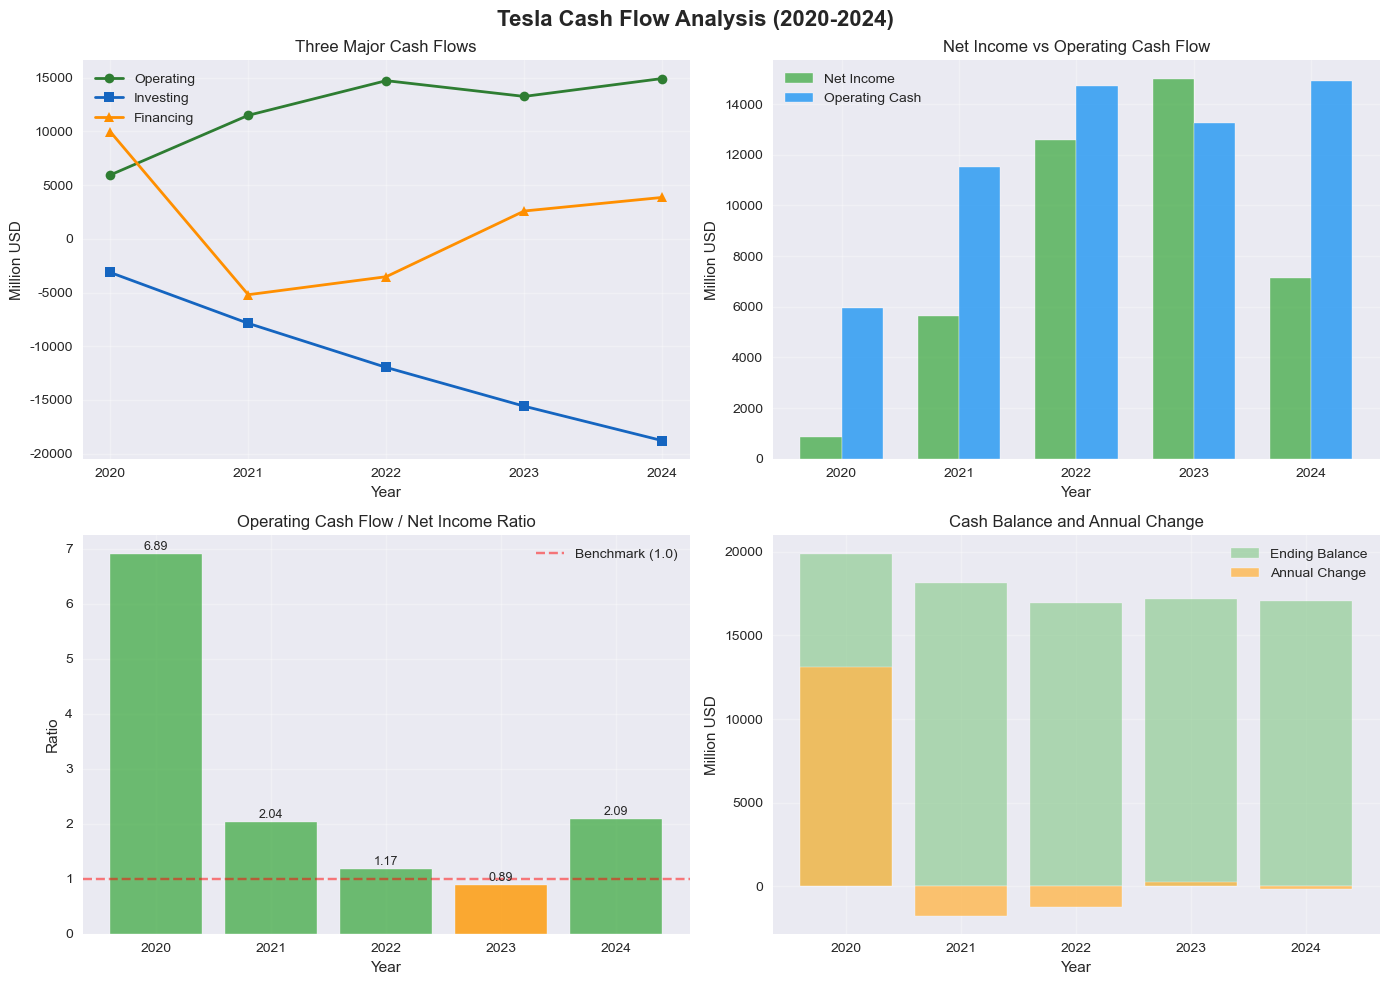

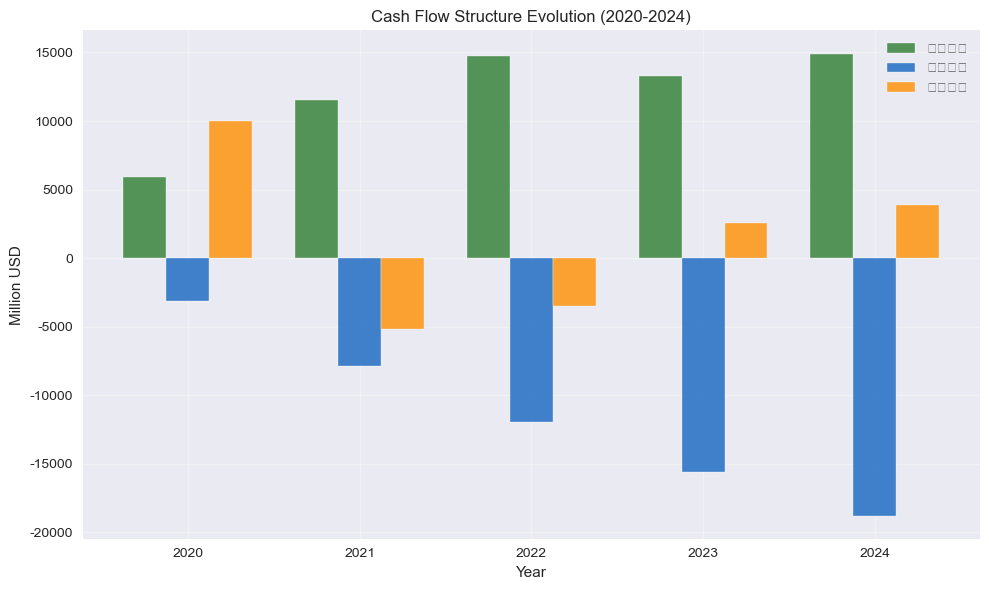

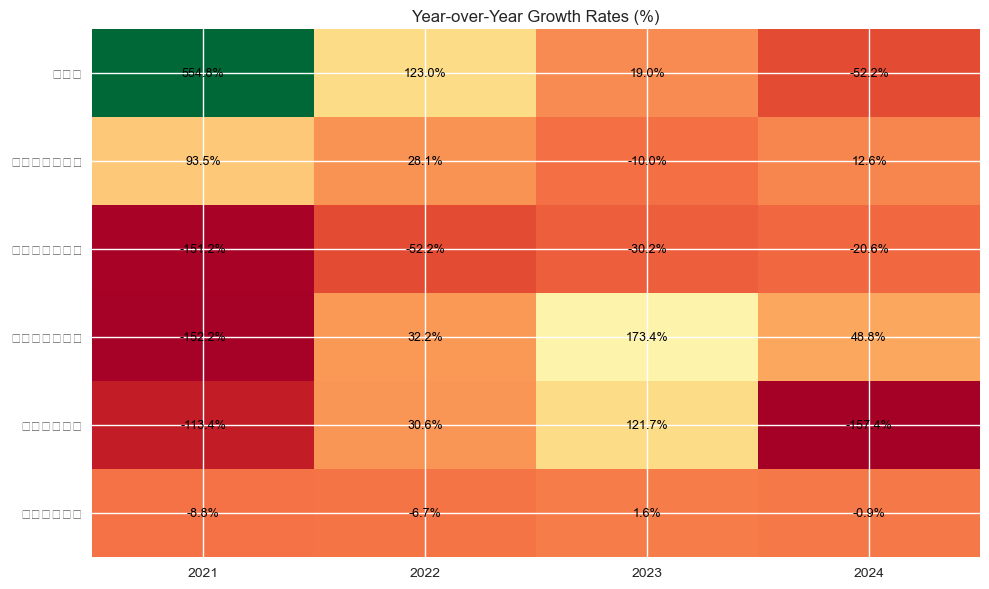


🎯 分析要点:
   • 特斯拉2024年净利润为$7,153M
   • 经营现金流为净利润的2.09倍
   • 现金储备充足: $17,037M
   • 财务健康状况: 良好


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import re
import matplotlib
import warnings
import logging

# 配置日志 - 减少不必要的输出
logging.getLogger('matplotlib').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

# 设置中文字体 - 使用英文标签避免字体问题
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

# 文件路径
file_path = r"F:\tesla-optimus-business-analysis\data\processed\cash flow.xlsx"
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

print("正在读取特斯拉现金流量表数据...")
print("="*60)

# 读取数据
df = pd.read_excel(file_path, sheet_name='Sheet1', header=0)

# 清理列名
df.columns = ['Description'] + [str(col) for col in df.columns[1:]]

print(f"✓ 数据读取成功")
print(f"  数据形状: {df.shape}")
print(f"  数据列: {list(df.columns)}")

# 显示关键数据预览
print("\n数据预览 (前5行):")
print(df.head().to_string(index=False))

# 1. 提取关键财务指标
print("\n" + "="*60)
print("提取关键财务指标")
print("="*60)

# 手动定义关键指标数据（从预览数据中识别）
metrics_data = {
    '净利润': [862, 5644, 12587, 14974, 7153],  # Net income
    '经营活动现金流': [5943, 11497, 14724, 13256, 14923],  # Net cash provided by operating activities
    '投资活动现金流': [-3132, -7868, -11973, -15584, -18787],  # Net cash used in investing activities
    '筹资活动现金流': [9973, -5203, -3527, 2589, 3853],  # Net cash provided by financing activities
    '现金净增加额': [13118, -1757, -1220, 265, -152],  # Net (decrease) increase in cash
    '期末现金余额': [19901, 18144, 16924, 17189, 17037]  # Cash and cash equivalents, end of period
}

years = ['2020', '2021', '2022', '2023', '2024']
metrics_df = pd.DataFrame(metrics_data, index=years).T

print("✓ 关键财务指标提取完成 (单位: 百万美元)")
print(metrics_df.to_string())

# 2. 现金流结构分析
print("\n" + "-"*60)
print("现金流结构分析")
print("-"*60)

cash_flow_components = pd.DataFrame(index=years, columns=['经营活动', '投资活动', '筹资活动', '现金净增加'])

for year in years:
    cash_flow_components.loc[year, '经营活动'] = metrics_df.loc['经营活动现金流', year]
    cash_flow_components.loc[year, '投资活动'] = metrics_df.loc['投资活动现金流', year]
    cash_flow_components.loc[year, '筹资活动'] = metrics_df.loc['筹资活动现金流', year]
    cash_flow_components.loc[year, '现金净增加'] = metrics_df.loc['现金净增加额', year]

print("现金流构成 (百万美元):")
print(cash_flow_components.to_string())

# 3. 盈利能力与现金流质量分析
print("\n" + "-"*60)
print("盈利能力与现金流质量分析")
print("-"*60)

profitability_df = pd.DataFrame(index=years, columns=['净利润', '经营活动现金流', '现金流/净利润比率'])

for year in years:
    net_income = metrics_df.loc['净利润', year]
    operating_cash = metrics_df.loc['经营活动现金流', year]
    
    # 计算现金流与净利润比率
    cash_to_profit_ratio = operating_cash / net_income if net_income != 0 else np.nan
    
    profitability_df.loc[year, '净利润'] = net_income
    profitability_df.loc[year, '经营活动现金流'] = operating_cash
    profitability_df.loc[year, '现金流/净利润比率'] = cash_to_profit_ratio

print("盈利能力与现金流质量:")
print(profitability_df.round(2).to_string())

# 4. 趋势分析
print("\n" + "-"*60)
print("趋势分析 - 同比增长率")
print("-"*60)

# 计算增长率
metrics_growth = pd.DataFrame(index=metrics_df.index, columns=['2021', '2022', '2023', '2024'])

for metric in metrics_df.index:
    values = metrics_df.loc[metric]
    
    for i in range(1, 5):  # 计算从2021到2024的增长率
        current_year = str(2020 + i)
        prev_year = str(2020 + i - 1)
        
        current_val = values[current_year]
        prev_val = values[prev_year]
        
        if prev_val != 0:
            growth_rate = (current_val - prev_val) / abs(prev_val) * 100
            metrics_growth.loc[metric, current_year] = f"{growth_rate:.1f}%"
        else:
            metrics_growth.loc[metric, current_year] = "N/A"

print("关键指标同比增长率:")
print(metrics_growth.to_string())

# 5. 现金流健康状况评估
print("\n" + "-"*60)
print("现金流健康状况评估")
print("-"*60)

for year in years:
    operating = metrics_df.loc['经营活动现金流', year]
    investing = metrics_df.loc['投资活动现金流', year]
    financing = metrics_df.loc['筹资活动现金流', year]
    
    print(f"\n{year}年评估:")
    print(f"  经营活动现金流: {operating:,.0f} 百万美元", end=" - ")
    print("✓ 健康" if operating > 0 else "⚠ 需关注" if operating < 0 else "○ 平稳")
    
    print(f"  投资活动现金流: {investing:,.0f} 百万美元", end=" - ")
    print("⚡ 扩张期" if investing < 0 else "📊 收缩期" if investing > 0 else "○ 平稳")
    
    print(f"  筹资活动现金流: {financing:,.0f} 百万美元", end=" - ")
    print("💰 外部融资" if financing > 0 else "💳 债务偿还" if financing < 0 else "○ 平稳")
    
    # 现金流自给能力
    if operating + investing >= 0:
        print(f"  现金流自给能力: ✓ 可自给自足")
    else:
        print(f"  现金流自给能力: ⚠ 需外部融资")

# 6. 投资活动分析
print("\n" + "-"*60)
print("主要投资活动分析")
print("-"*60)

# 从原始数据提取主要投资活动
investment_items = [
    ('固定资产采购', 'Purchases of property and equipment'),
    ('太阳能系统', 'Purchases of solar energy systems'),
    ('数字资产', 'Purchases of digital assets'),
    ('投资收益', 'Proceeds from sales of investments'),
    ('投资赎回', 'Proceeds from maturities of investments')
]

print("2024年主要投资活动:")
for chinese_name, eng_keyword in investment_items:
    # 查找相关行
    for desc in df['Description']:
        if isinstance(desc, str) and eng_keyword.lower() in desc.lower():
            row_idx = df[df['Description'] == desc].index[0]
            value = df.loc[row_idx, '2024']
            if pd.notna(value) and value != 0:
                print(f"  {chinese_name}: {value:,.0f} 百万美元")
            break

# 7. 可视化分析
print("\n" + "="*60)
print("生成可视化图表")
print("="*60)

# 创建图表保存目录
chart_dir = os.path.join(desktop_path, "Tesla_Cash_Flow_Analysis")
os.makedirs(chart_dir, exist_ok=True)

# 图表1: 三大现金流趋势
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Tesla Cash Flow Analysis (2020-2024)', fontsize=16, fontweight='bold')

# 1.1 三大现金流趋势
ax = axes[0, 0]
years_int = [2020, 2021, 2022, 2023, 2024]

ax.plot(years_int, metrics_df.loc['经营活动现金流'], marker='o', linewidth=2, label='Operating', color='#2E7D32')
ax.plot(years_int, metrics_df.loc['投资活动现金流'], marker='s', linewidth=2, label='Investing', color='#1565C0')
ax.plot(years_int, metrics_df.loc['筹资活动现金流'], marker='^', linewidth=2, label='Financing', color='#FF8F00')

ax.set_xlabel('Year')
ax.set_ylabel('Million USD')
ax.set_title('Three Major Cash Flows')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(years_int)

# 1.2 净利润与经营现金流对比
ax = axes[0, 1]
width = 0.35
x = np.arange(len(years))

ax.bar(x - width/2, metrics_df.loc['净利润'], width, label='Net Income', alpha=0.8, color='#4CAF50')
ax.bar(x + width/2, metrics_df.loc['经营活动现金流'], width, label='Operating Cash', alpha=0.8, color='#2196F3')

ax.set_xlabel('Year')
ax.set_ylabel('Million USD')
ax.set_title('Net Income vs Operating Cash Flow')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
ax.grid(True, alpha=0.3)

# 1.3 现金流比率
ax = axes[1, 0]
cash_profit_ratio = profitability_df['现金流/净利润比率'].astype(float)
colors = ['#4CAF50' if ratio > 1 else '#FF9800' if ratio > 0.5 else '#F44336' for ratio in cash_profit_ratio]

bars = ax.bar(years, cash_profit_ratio, color=colors, alpha=0.8)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Benchmark (1.0)')
ax.set_xlabel('Year')
ax.set_ylabel('Ratio')
ax.set_title('Operating Cash Flow / Net Income Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# 添加数值标签
for bar, ratio in zip(bars, cash_profit_ratio):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{ratio:.2f}', ha='center', va='bottom', fontsize=9)

# 1.4 现金余额变化
ax = axes[1, 1]
cash_balance = metrics_df.loc['期末现金余额']
cash_change = metrics_df.loc['现金净增加额']

ax.bar(years, cash_balance, color='#81C784', alpha=0.6, label='Ending Balance')
ax.bar(years, cash_change, color='#FFB74D', alpha=0.8, label='Annual Change')

ax.set_xlabel('Year')
ax.set_ylabel('Million USD')
ax.set_title('Cash Balance and Annual Change')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
chart1_path = os.path.join(chart_dir, "Tesla_Cash_Flow_Trends.png")
plt.savefig(chart1_path, dpi=300, bbox_inches='tight')
print(f"✓ 已保存图表1: Tesla_Cash_Flow_Trends.png")

# 图表2: 现金流结构演变
fig, ax = plt.subplots(figsize=(10, 6))

# 准备数据
cash_structure = cash_flow_components[['经营活动', '投资活动', '筹资活动']].T

# 转换年份为数值类型用于绘图
x_positions = np.arange(len(years))
bar_width = 0.25

# 绘制分组柱状图
for i, (activity, values) in enumerate(cash_structure.iterrows()):
    offset = (i - 1) * bar_width
    colors = ['#2E7D32', '#1565C0', '#FF8F00']
    ax.bar(x_positions + offset, values.values, bar_width, 
           label=activity, color=colors[i], alpha=0.8)

ax.set_xlabel('Year')
ax.set_ylabel('Million USD')
ax.set_title('Cash Flow Structure Evolution (2020-2024)')
ax.set_xticks(x_positions)
ax.set_xticklabels(years)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
chart2_path = os.path.join(chart_dir, "Tesla_Cash_Flow_Structure.png")
plt.savefig(chart2_path, dpi=300, bbox_inches='tight')
print(f"✓ 已保存图表2: Tesla_Cash_Flow_Structure.png")

# 图表3: 关键指标增长率热力图
fig, ax = plt.subplots(figsize=(10, 6))

# 准备增长率数据
growth_data = []
for metric in metrics_df.index:
    row = []
    for year in ['2021', '2022', '2023', '2024']:
        rate_str = metrics_growth.loc[metric, year]
        if rate_str != 'N/A':
            rate = float(rate_str.replace('%', ''))
            row.append(rate)
        else:
            row.append(0)
    growth_data.append(row)

# 创建热力图
im = ax.imshow(growth_data, cmap='RdYlGn', aspect='auto')

# 设置标签
ax.set_xticks(np.arange(len(['2021', '2022', '2023', '2024'])))
ax.set_yticks(np.arange(len(metrics_df.index)))
ax.set_xticklabels(['2021', '2022', '2023', '2024'])
ax.set_yticklabels(metrics_df.index)

# 添加数值标签
for i in range(len(metrics_df.index)):
    for j in range(4):
        rate_str = metrics_growth.iloc[i, j]
        if rate_str != 'N/A':
            text = ax.text(j, i, rate_str, ha="center", va="center", color="black", fontsize=9)

ax.set_title('Year-over-Year Growth Rates (%)')
plt.tight_layout()
chart3_path = os.path.join(chart_dir, "Tesla_Growth_Rates_Heatmap.png")
plt.savefig(chart3_path, dpi=300, bbox_inches='tight')
print(f"✓ 已保存图表3: Tesla_Growth_Rates_Heatmap.png")

# 8. 生成分析报告
print("\n" + "="*60)
print("特斯拉现金流量表分析报告摘要")
print("="*60)

latest_year = '2024'
latest_operating = metrics_df.loc['经营活动现金流', latest_year]
latest_investing = metrics_df.loc['投资活动现金流', latest_year]
latest_financing = metrics_df.loc['筹资活动现金流', latest_year]
latest_cash_balance = metrics_df.loc['期末现金余额', latest_year]
latest_net_income = metrics_df.loc['净利润', latest_year]

print(f"\n📊 2024年财务状况概览:")
print(f"   净利润: ${latest_net_income:,.0f}M")
print(f"   经营现金流: ${latest_operating:,.0f}M")
print(f"   投资现金流: ${latest_investing:,.0f}M")
print(f"   筹资现金流: ${latest_financing:,.0f}M")
print(f"   期末现金: ${latest_cash_balance:,.0f}M")

# 现金流质量分析
cash_quality = latest_operating / latest_net_income if latest_net_income != 0 else 0
print(f"\n💎 现金流质量分析:")
if cash_quality > 1.5:
    print(f"   优秀: 经营现金流是净利润的{cash_quality:.2f}倍")
elif cash_quality > 1:
    print(f"   良好: 经营现金流是净利润的{cash_quality:.2f}倍")
elif cash_quality > 0.5:
    print(f"   一般: 经营现金流是净利润的{cash_quality:.2f}倍")
elif cash_quality > 0:
    print(f"   较差: 经营现金流仅占净利润的{cash_quality:.2f}倍")
else:
    print(f"   严重: 经营现金流为负")

print(f"\n🏥 财务健康状况:")
if latest_operating > 0:
    if latest_operating + latest_investing >= 0:
        print("   ✅ 健康: 经营现金流足以覆盖投资需求")
    else:
        print("   ⚠️ 关注: 经营现金流不足，需外部融资")
else:
    print("   ❌ 风险: 经营现金流为负，需密切关注")

print(f"\n📈 发展趋势 (2020-2024):")
# 分析趋势
operating_trend = metrics_df.loc['经营活动现金流'].astype(float)
if all(np.diff(operating_trend) > 0):
    print("   经营现金流: 持续增长 ✓")
elif operating_trend.iloc[-1] > operating_trend.iloc[0]:
    print("   经营现金流: 总体增长 ↗")
else:
    print("   经营现金流: 增长放缓 ⬇")

# 现金余额趋势
cash_trend = metrics_df.loc['期末现金余额'].astype(float)
if cash_trend.iloc[-1] > 15000:  # 超过150亿美元
    print(f"   现金储备: 充足 (${cash_trend.iloc[-1]:,.0f}M)")

# 9. 保存分析结果到Excel
output_excel_path = os.path.join(desktop_path, "Tesla_Cash_Flow_Analysis_Report.xlsx")

with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    metrics_df.to_excel(writer, sheet_name='Key_Metrics')
    cash_flow_components.to_excel(writer, sheet_name='Cash_Flow_Structure')
    profitability_df.to_excel(writer, sheet_name='Profitability')
    metrics_growth.to_excel(writer, sheet_name='Growth_Rates')
    
    # 添加分析摘要
    summary_data = {
        '指标': ['2024年净利润', '2024年经营现金流', '现金流质量比率', '期末现金余额', '财务健康状况'],
        '数值': [
            f"${latest_net_income:,.0f}M",
            f"${latest_operating:,.0f}M",
            f"{cash_quality:.2f}",
            f"${latest_cash_balance:,.0f}M",
            "健康" if latest_operating > 0 and latest_operating + latest_investing >= 0 else "需关注"
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Analysis_Summary', index=False)

print(f"\n" + "="*60)
print("分析完成!")
print("="*60)
print(f"📁 分析报告已保存:")
print(f"   1. Excel报告: {output_excel_path}")
print(f"   2. 图表目录: {chart_dir}")
print(f"      • Tesla_Cash_Flow_Trends.png")
print(f"      • Tesla_Cash_Flow_Structure.png")
print(f"      • Tesla_Growth_Rates_Heatmap.png")

# 显示图表
plt.show()

print(f"\n🎯 分析要点:")
print(f"   • 特斯拉2024年净利润为${latest_net_income:,.0f}M")
print(f"   • 经营现金流为净利润的{cash_quality:.2f}倍")
print(f"   • 现金储备充足: ${latest_cash_balance:,.0f}M")
print(f"   • 财务健康状况: {'良好' if latest_operating > 0 else '需关注'}")